<div align="center">

# unZipro  [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Gabriel-QIN/unZipro/blob/master/notebooks/unZipro.ipynb)  [![GitHub](https://img.shields.io/badge/-GitHub-181717?logo=github&logoColor=white)](https://github.com/Gabriel-Qin/unZipro)  [![Server Status](https://img.shields.io/badge/Website-unZipro-green)](https://ai4bio.online/unZipro/home)

> **This is the official Google Colab tutorial of _unZipro_** — an unsupervised zero-shot inverse folding framework for protein evolution and high-fitness variant prediction.

</div>

---

<div align="center">
<img src="https://raw.githubusercontent.com/Gabriel-QIN/unZipro/master/image/easy_workflow.png" width="80%">
</div>

# Overview

**unZipro** (<u>un</u>supervised Zero-shot <u>i</u>nverse folding framework for <u>pro</u>tein evolution) is a lightweight **graph neural network (GNN)-based framework** designed for AI-guided protein engineering.

By combining general inverse folding constraints with family-specific adaptation, unZipro efficiently prioritizes high-fitness mutations without exhaustive screening.

<div align="center">
<img src="https://raw.githubusercontent.com/Gabriel-QIN/unZipro/master/image/applications.png" width="80%">
</div>

## ⚙️ How it works

unZipro tackles protein engineering like “hunting for the needle in the haystack”:

- 🧠 **Zero-shot transfer learning** captures a universal protein fitness landscape.
- 🧩 **Meta-learning** adapts to family-specific fitness landscapes.
- ✅ **Prioritization** of the most promising high-fitness variants for experimental validation.

---



# 1. Installation

In [1]:
#@title Install unZipro {display-mode: "form"}
! rm -rf unZipro
!git clone https://github.com/Gabriel-Qin/unZipro.git

Cloning into 'unZipro'...
remote: Enumerating objects: 3533, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 3533 (delta 49), reused 66 (delta 25), pack-reused 3442 (from 1)
Receiving objects: 100% (3533/3533), 67.23 MiB | 1.66 MiB/s, done.
Resolving deltas: 100% (480/480), done.


In [2]:
#@title Install unZipro and dependencies {display-mode: "form"}
!git clone https://github.com/Gabriel-Qin/unZipro.git
!pip install numpy pandas biotite requests plotly py3Dmol
### Install PyTorch
# !pip install torch==2.4.1+cu124 --index-url https://download.pytorch.org/whl/cu124rch==2.4.1+cu124 --index-url https://download.pytorch.org/whl/cu124
### Install learn2learn from source
!git clone https://github.com/learnables/learn2learn.git
%cd learn2learn
!pip install -e .
%cd ..
# !pip install learn2learn ## Install via pip
print("✅ unZipro installation complete.")

fatal: destination path 'unZipro' already exists and is not an empty directory.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple/
✅ unZipro installation complete.


# 2. Zero-shot inference (without fine-tuning)

In [3]:
#@title unZipro Mutation Prioritization {display-mode: "form"}
pdb_code = "7lys"  #@param {type:"string"}
chain_id = "A" #@param {type:"string"}
temperature = 1.0  #@param {type:"number"}
nneighbor = 20  #@param {type:"number"}

import os
import json
import torch
import torch.nn as nn
from unZipro.script.utils import *
from unZipro.script.model import unZipro
from unZipro.script.fetch_PDB_parallel import safe_fetch
from unZipro.script.unZipro_mutation import infer_single_protein

model_param = 'unZipro/Models/unZipro_params.pt'
cache_dir = 'tmp/'
outdir = 'output'
config_path = 'unZipro/config/unZipro_pretrain.json'
pdb_dir = 'PDB'
pdb_name = f'{pdb_code}{chain_id}'
os.makedirs(outdir, exist_ok=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
res = None
print(f"INFO | Starting mutation prioritization for {pdb_name} with res={res or 'ALL'}")

safe_fetch(pdb_name, pdb_dir)

with open(config_path, "r") as f:
    data = json.load(f)
model_config = Config(**data)
model = unZipro(model_config).to(device)
state_dict = torch.load(model_param, map_location=device, weights_only=True)
try:
    model.load_state_dict(state_dict)
except:
    new_state_dict = {k.replace("module.", ""):v for k,v in state_dict.items()}
    model.load_state_dict(new_state_dict)

dataset = GraphDataset(
    datalist=[os.path.join(pdb_dir, f'{pdb_name}.pdb')],
    nneighbor=nneighbor,
    noise=0,
    cache_dir=cache_dir
)
loader = get_loader(dataset=dataset, batchsize=1)
criterion = nn.CrossEntropyLoss().to(device)
model.eval()

df_list = infer_single_protein(
    model, criterion, loader, pdb_dir, outdir,
    temperature=temperature, device=device,
    output_prob=True, output_logits=True,
    rank_by_prob=True, res=res or None
)
print("✅ Done! Results saved in", outdir)


INFO | Starting mutation prioritization for 7lysA with res=ALL
✅ Downloaded 7lysA
[INFO] 7lysA | Recovery: 38.20% | Loss: 2.1656
[INFO] Saved in silico mutation scores to output/7lysA.info.csv!
[INFO] Saved ranked scores to output/7lysA.info_rank_by_prob.csv!
[INFO] Saved per-residue probability matrix  to output/7lysA.info_probs.csv!
[INFO] Saved per-residue logits to output/7lysA.info_logits.csv!
    Name      Time
0  7lysA  0.612846
Total time: 0.613 s
Average per item: 0.613 s
✅ Done! Results saved in output


### Visualize fitness landscape

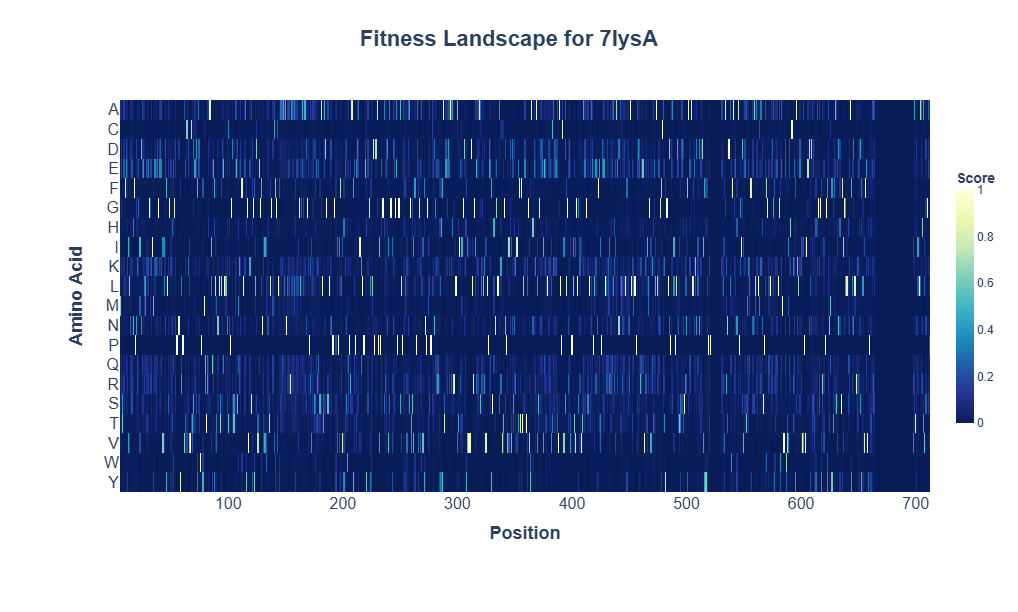

In [4]:
#@title Fitness Landscape Viewer {display-mode:"form"}
color_scale = "YlGnBu_r"  #@param ["YlGnBu_r","Viridis","Cividis","Plasma","Inferno"]
fig_width = 1400  #@param {type:"number"}
fig_height = 600  #@param {type:"number"}
font_size = 14  #@param {type:"number"}
title_size = 22  #@param {type:"number"}

import pandas as pd
import plotly.express as px

# 读取 CSV
df = pd.read_csv(f'{outdir}/{pdb_name}.info_probs.csv')
aa_cols = [c for c in df.columns if c.startswith("prob_")]

# Prepare score matrix
score = df[aa_cols].copy()
score_T = score.T
score_T.index = [c.replace("prob_", "") for c in aa_cols]
score_T.columns = df["auth_idx"]

# 绘制热图
fig = px.imshow(
    score_T,
    color_continuous_scale=color_scale,
    aspect="auto",
    labels=dict(color="Fitness"),
    title=f"<b>Fitness Landscape for {pdb_name}</b>",
)

fig.update_layout(
    width=fig_width,
    height=fig_height,
    font=dict(family="Arial", size=font_size),
    title=dict(x=0.5, y=0.95, font=dict(size=title_size)),
    xaxis_title="<b>Position</b>",
    yaxis_title="<b>Amino Acid</b>",
    margin=dict(l=120, r=80, t=100, b=120),
    coloraxis_colorbar=dict(
        title="<b>Score</b>",
        thickness=18,
        len=0.7,
        tickfont=dict(size=12)
    )
)

fig.update_xaxes(
    tickfont=dict(family="Arial", size=16),
    tickangle=0,
    showgrid=False,
    title_font=dict(family="Arial", size=18)
)
fig.update_yaxes(
    tickfont=dict(family="Arial", size=16), 
    showgrid=False,
    title_font=dict(family="Arial", size=18)
)

fig.update_traces(
    xgap=0, ygap=0,
    hovertemplate="AA: %{y}<br>Pos: %{x}<br>Value: %{z}<extra></extra>"
)

fig.show()


### Prioritization of mutations on structure

In [5]:
#@title 3D Structure Viewer (click to expand) {display-mode:"form"}
! pip install py3Dmol
import py3Dmol
import pandas as pd
import matplotlib.cm as cm

style = "cartoon"  #@param ["cartoon", "rainbow"]
highlight_color = "salmon"  #@param ["salmon", "red", "yellow", "cyan"]
sphere_size = 1.0  #@param {type:"number"}
stick_size = 0.3  #@param {type:"number"}

mut_df = pd.read_csv(f'{outdir}/{pdb_name}.info_rank_by_prob.csv')
top_mut = mut_df.sort_values("mut_prob", ascending=False).head(10)
top_positions = top_mut["auth_idx"].tolist()
top_values = top_mut["mut_prob"].tolist()

with open(f"{pdb_dir}/{pdb_name}.pdb", "r") as f:
    pdb_data = f.read()

view = py3Dmol.view(width=900, height=650)
view.addModel(pdb_data, 'pdb')

if style == "cartoon":
    view.setStyle({'cartoon': {
        'color': 'lightblue',
        'opacity': 0.85,
        'smooth': True,
        'thickness': 0.5
    }})
elif style == "rainbow":
    view.setStyle({'cartoon': {'color': 'spectrum'}})

color_dict = {
    "salmon": "rgb(250,128,114)",
    "red":    "rgb(255,0,0)",
    "yellow": "rgb(255,215,0)",
    "cyan":   "rgb(0,255,255)"
}
HL = color_dict[highlight_color]

for pos in top_positions:
    view.addStyle(
        {'resi': str(pos), 'atom': 'CA'},
        {'sphere': {'color': HL, 'radius': sphere_size},
         'stick':  {'color': HL, 'radius': stick_size}}
    )

view.setBackgroundColor("white")
view.zoomTo()
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

# 3.Family-specific inference (meta transfer learning)

In [6]:
#@title unZipro family-specific fine-tuning {display-mode: "form"}
pdb_code = "7lys"  #@param {type:"string"}
chain_id = "A" #@param {type:"string"}
temperature = 1.0  #@param {type:"number"}
nneighbor = 20  #@param {type:"number"}
train_size = 100 #@param {type:"number"}
patience = 5 #@param {type:"number"}
epochs = 10 #@param {type:"number"}
adapt_step = 10 #@param {type:"number"}

import os
import sys
import time
import json
import argparse
from tempfile import gettempdir
from concurrent.futures import ThreadPoolExecutor
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import learn2learn as l2l
from tqdm import tqdm
import requests
import biotite.structure as struc
import biotite.structure.io as strucio
from unZipro.script.utils import *
from unZipro.script.model import unZipro, weights_init
from unZipro.script.foldseek_api import submit_pdb_to_foldseek, parse_pdb_input
from unZipro.script.parse_foldseek_results import parse_mmseqs, write_ids
from unZipro.script.fetch_PDB_parallel import fetch_and_save, safe_fetch
from unZipro.script.unZipro_finetuning import unZipro_finetune
from unZipro.script.unZipro_mutation import infer_single_protein

outdir = 'output'
pdb_dir = 'pdb'
work_dir = './'
train_size = 100
config_path = 'unZipro/config/unZipro_pretrain.json'
param = 'unZipro/Models/unZipro_params.pt'
cache_dir = 'tmp/'
outdir = 'output'
pdb_name = f'{pdb_code}{chain_id}'
safe_fetch(pdb_name, pdb_dir)
os.makedirs(outdir, exist_ok=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
adapt_lr = 1e-6
meta_lr = 1e-6
res = None
print(f"INFO | Step 1: start to retrieve similar structures using Foldseek!")
_ = submit_pdb_to_foldseek(
    pdb_list=parse_pdb_input(pdb_name),
    outdir=work_dir,
    pdb_dir=pdb_dir,
    use_wget=True,
    use_aria2c=False,
    wait_time=30,
    only_download=False
)
print(f"INFO | Step 2: split data into meta-training and testing!")
try:
    m8_path = os.path.join(work_dir, f'{pdb_name}/alis_pdb100.m8')
    savepath = os.path.join(work_dir, f'{pdb_name}_pdb100.csv')
    data_dir = os.path.join(work_dir, f'{pdb_name}/')
    pdb_id_path = os.path.join(data_dir, 'PDB_IDs.txt')
    os.makedirs(data_dir, exist_ok=True)
    train_path = os.path.join(data_dir, f'train.csv')
    test_path = os.path.join(data_dir, f'test.csv')
    train, test, download_pdblist, num_pdbs, num_af_pdbs = parse_mmseqs(m8_path, savepath, train_path, test_path, train_size=train_size, include_af2=True)
    if len(train) < 10 or len(test) < 10:
        raise ValueError(f"Too little homologs for {pdb_name} Train size {len(train)} | Test size {len(test)}!")
    if len(train) < 100 or len(test) < 20:
        print(f'Warning! [{pdb_name}]: Train size {len(train)} | Test size {len(test)}')
except Exception as e:
    print(f'Error in {pdb_name}: {e}')
print(f"INFO | Step 3: start to download structural data!")
pdb_dir = os.path.join(work_dir, 'pdb')
os.makedirs(pdb_dir, exist_ok=True)
print(f"INFO | Found {len(train)} meta-training structures and {len(test)} meta-testing structures!")
with ThreadPoolExecutor(max_workers=4) as executor:
    # futures = [executor.submit(fetch_and_save, pdb, pdb_dir) for pdb in download_pdblist]
    futures = [executor.submit(safe_fetch, pdb, pdb_dir) for pdb in download_pdblist]
    for f in futures:
        f.result()
print(f"INFO | Step 4: start unZipro finetuning!")
model_store_dir = os.path.join(work_dir, 'model/')
cache_dir = os.path.join(work_dir, 'tmp/')
# unZipro finetuning
model_param = unZipro_finetune(train_path, test_path, config_path=config_path, pdb_dir=pdb_dir, model_store_dir=model_store_dir, 
                param_file=param, project_name=pdb_name, epochs=epochs, 
                adapt_lr=adapt_lr, meta_lr=meta_lr, adapt_step=adapt_step, 
                batchsize=1, cpu=4, gpu=0,cpu_only=False,
                noise=0.01, nneighbor=nneighbor, patience=patience, cache_dir=cache_dir, save_model_ckp=False)
os.system(f'rm -rf {cache_dir}/*')
model_param = f'{model_store_dir}/{pdb_name}.pt'
print(f"INFO | Step 5: start mutation prioritation!")
os.makedirs(f'{outdir}', exist_ok=True)
device = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')
with open(config_path, "r") as f:
    data = json.load(f)
model_config = Config(**data)
model = unZipro(model_config).to(device)
state_dict = torch.load(model_param, map_location=torch.device(device), weights_only=True)
try:
    model.load_state_dict(state_dict)
except:
    new_state_dict = {k.replace("module.", ""):v for k,v in state_dict.items()}
    model.load_state_dict(new_state_dict)
# dataloader setup
dataset = GraphDataset(datalist=[osp.join(pdb_dir, f'{pdb_name}.pdb')], nneighbor=nneighbor, noise=0, cache_dir=cache_dir)
loader = get_loader(dataset=dataset, batchsize=1)
criterion = nn.CrossEntropyLoss().to(device)
model.eval()
df_list= infer_single_protein(model, criterion, loader, pdb_dir, outdir, temperature=1.0, device=device, output_prob=True, output_logits=True, rank_by_prob=True, res=res)
end = time.perf_counter()
print("✅ Done! Results saved in", outdir)

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


✅ Downloaded 7lysA
INFO | Step 1: start to retrieve similar structures using Foldseek!
Status: 200 | Response: {"id":"MNPc7R7CFGhMRK_JHZZgUsVcnPqbUsREGVh1Gw","status":"COMPLETE"}

Query 7lysA | Ticket: MNPc7R7CFGhMRK_JHZZgUsVcnPqbUsREGVh1Gw
Processed 1/1: 7lysA. Waiting 30s...
All tasks submitted. Now waiting for results...
Executing download script for 7lysA...


--2025-11-18 15:52:10--  https://search.foldseek.com/api/result/download/MNPc7R7CFGhMRK_JHZZgUsVcnPqbUsREGVh1Gw
Resolving search.foldseek.com (search.foldseek.com)... 158.247.200.62
Connecting to search.foldseek.com (search.foldseek.com)|158.247.200.62|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘.//7lysA.tar.gz’

     0K .......... .......... .......... .......... ..........  225K
    50K .......... .......... .......... .......... ..........  538K
   100K .......... .......... .......... .......... ..........  764K
   150K .......... .......... .......... .......... .......... 1.16M
   200K .......... .......... .......... .......... .......... 1.33M
   250K .......... .......... .......... .......... .......... 1.42M
   300K .......... .......... .......... .......... .......... 1.80M
   350K .......... .......... .......... .......... .......... 1.62M
   400K .......... .......... .......... .......... 

7lysA
alis_afdb50.m8
alis_afdb50_report.m8
alis_pdb100.m8
alis_pdb100_report.m8
Download completed for 7lysA.
All tasks processed and results downloaded.
INFO | Step 2: split data into meta-training and testing!
INFO | Step 3: start to download structural data!
INFO | Found 100 meta-training structures and 20 meta-testing structures!
✅ Downloaded 4fsvA
✅ Downloaded 5fpnB
✅ Downloaded 6lu0A
✅ Downloaded 6nagB
✅ Downloaded 7kziB
✅ Downloaded 7epqA
✅ Downloaded 7krvA
✅ Downloaded 5l20A
✅ Downloaded 7nquB
✅ Downloaded 6nagA
✅ Downloaded 7kruB
✅ Downloaded 5fpdA
✅ Downloaded 3kvgA
✅ Downloaded 7krvB
✅ Downloaded 7o0gA
✅ Downloaded 5f0xB
✅ Downloaded 7krtC
✅ Downloaded 5aqwA
✅ Downloaded 7nquA
✅ Downloaded 6gfaA
✅ Downloaded 8h9dA
✅ Downloaded 8sjdA
✅ Downloaded 5xh7A
✅ Downloaded 2apjC
✅ Downloaded 5xh6A
✅ Downloaded 4hkqA
✅ Downloaded 2apjD
✅ Downloaded 6iv6A
✅ Downloaded 6gq1k
✅ Downloaded 1czaN
✅ Downloaded 7q3eA
✅ Downloaded 5mb9B
✅ Downloaded 7n1rA
✅ Downloaded 4gniB
✅ Downloaded 3i33A

/mnt/data2024/zhqin/open_source/unZipro/notebooks/unZipro/script/unZipro_finetuning.py:133: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

Finetuning:  10%|████▌             

Epoch 1 | Train Loss: 1.8301 | Train Acc: 45.40% | Valid Loss: 2.1518 | Valid Acc: 39.37%


Finetuning:  20%|█████████                                    | 2/10 [00:41<02:38, 19.86s/epoch]

Epoch 2 | Train Loss: 1.8975 | Train Acc: 43.63% | Valid Loss: 2.1170 | Valid Acc: 37.89%


Finetuning:  30%|█████████████▌                               | 3/10 [00:56<02:04, 17.72s/epoch]

Epoch 3 | Train Loss: 1.8762 | Train Acc: 44.50% | Valid Loss: 2.1459 | Valid Acc: 38.36%


Finetuning:  40%|██████████████████                           | 4/10 [01:08<01:32, 15.45s/epoch]

Epoch 4 | Train Loss: 1.8554 | Train Acc: 44.72% | Valid Loss: 2.1710 | Valid Acc: 37.34%


Finetuning:  50%|██████████████████████▌                      | 5/10 [01:21<01:11, 14.36s/epoch]

Epoch 5 | Train Loss: 1.8819 | Train Acc: 44.25% | Valid Loss: 2.2664 | Valid Acc: 36.37%


Finetuning:  60%|███████████████████████████                  | 6/10 [01:35<00:57, 14.41s/epoch]

Epoch 6 | Train Loss: 1.8065 | Train Acc: 45.70% | Valid Loss: 2.0289 | Valid Acc: 39.74%


Finetuning:  70%|███████████████████████████████▍             | 7/10 [01:49<00:42, 14.21s/epoch]

Epoch 7 | Train Loss: 1.8483 | Train Acc: 45.19% | Valid Loss: 2.1319 | Valid Acc: 39.84%


Finetuning:  80%|████████████████████████████████████         | 8/10 [02:03<00:28, 14.04s/epoch]

Epoch 8 | Train Loss: 1.8699 | Train Acc: 44.10% | Valid Loss: 2.3418 | Valid Acc: 35.57%


Finetuning:  90%|████████████████████████████████████████▌    | 9/10 [02:15<00:13, 13.48s/epoch]

Epoch 9 | Train Loss: 1.8060 | Train Acc: 45.69% | Valid Loss: 2.3277 | Valid Acc: 35.96%


Finetuning: 100%|████████████████████████████████████████████| 10/10 [02:28<00:00, 14.81s/epoch]


Epoch 10 | Train Loss: 1.9317 | Train Acc: 43.41% | Valid Loss: 2.3772 | Valid Acc: 35.54%
Finished training. Total elapsed time: 148s. Best valid loss: 2.0289 at epoch 6
INFO | Step 5: start mutation prioritation!
[INFO] 7lysA | Recovery: 40.00% | Loss: 2.0512
[INFO] Saved in silico mutation scores to output/7lysA.info.csv!
[INFO] Saved ranked scores to output/7lysA.info_rank_by_prob.csv!
[INFO] Saved per-residue probability matrix  to output/7lysA.info_probs.csv!
[INFO] Saved per-residue logits to output/7lysA.info_logits.csv!
    Name      Time
0  7lysA  0.238293
Total time: 0.238 s
Average per item: 0.238 s
✅ Done! Results saved in output


## Visualize fitness landscape

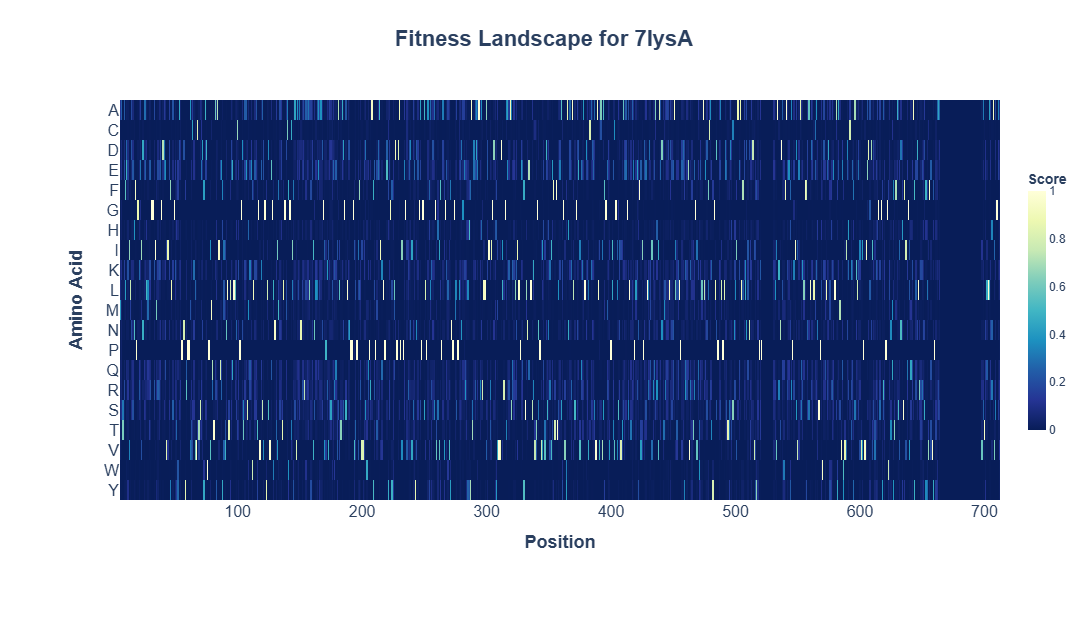

In [7]:
#@title Fitness Landscape Viewer {display-mode:"form"}
color_scale = "YlGnBu_r"  #@param ["YlGnBu_r","Viridis","Cividis","Plasma","Inferno"]
fig_width = 1400  #@param {type:"number"}
fig_height = 600  #@param {type:"number"}
font_size = 14  #@param {type:"number"}
title_size = 22  #@param {type:"number"}

import pandas as pd
import plotly.express as px

# 读取 CSV
df = pd.read_csv(f'{outdir}/{pdb_name}.info_probs.csv')
aa_cols = [c for c in df.columns if c.startswith("prob_")]

# Prepare score matrix
score = df[aa_cols].copy()
score_T = score.T
score_T.index = [c.replace("prob_", "") for c in aa_cols]
score_T.columns = df["auth_idx"]

# 绘制热图
fig = px.imshow(
    score_T,
    color_continuous_scale=color_scale,
    aspect="auto",
    labels=dict(color="Fitness"),
    title=f"<b>Fitness Landscape for {pdb_name}</b>",
)

fig.update_layout(
    width=fig_width,
    height=fig_height,
    font=dict(family="Arial", size=font_size),
    title=dict(x=0.5, y=0.95, font=dict(size=title_size)),
    xaxis_title="<b>Position</b>",
    yaxis_title="<b>Amino Acid</b>",
    margin=dict(l=120, r=80, t=100, b=120),
    coloraxis_colorbar=dict(
        title="<b>Score</b>",
        thickness=18,
        len=0.7,
        tickfont=dict(size=12)
    )
)

fig.update_xaxes(
    tickfont=dict(family="Arial", size=16),
    tickangle=0,
    showgrid=False,
    title_font=dict(family="Arial", size=18)
)
fig.update_yaxes(
    tickfont=dict(family="Arial", size=16), 
    showgrid=False,
    title_font=dict(family="Arial", size=18)
)

fig.update_traces(
    xgap=0, ygap=0,
    hovertemplate="AA: %{y}<br>Pos: %{x}<br>Value: %{z}<extra></extra>"
)

fig.show()


## Prioritization of mutations on structure

In [8]:
#@title 3D Structure Viewer (click to expand) {display-mode:"form"}
import py3Dmol
import pandas as pd
import matplotlib.cm as cm

style = "cartoon"  #@param ["cartoon", "rainbow"]
highlight_color = "salmon"  #@param ["salmon", "red", "yellow", "cyan"]
sphere_size = 1.0  #@param {type:"number"}
stick_size = 0.3  #@param {type:"number"}

mut_df = pd.read_csv(f'{outdir}/{pdb_name}.info_rank_by_prob.csv')
top_mut = mut_df.sort_values("mut_prob", ascending=False).head(10)
top_positions = top_mut["auth_idx"].tolist()
top_values = top_mut["mut_prob"].tolist()

with open(f"{pdb_dir}/{pdb_name}.pdb", "r") as f:
    pdb_data = f.read()

view = py3Dmol.view(width=900, height=650)
view.addModel(pdb_data, 'pdb')

if style == "cartoon":
    view.setStyle({'cartoon': {
        'color': 'lightblue',
        'opacity': 0.85,
        'smooth': True,
        'thickness': 0.5
    }})
elif style == "rainbow":
    view.setStyle({'cartoon': {'color': 'spectrum'}})

color_dict = {
    "salmon": "rgb(250,128,114)",
    "red":    "rgb(255,0,0)",
    "yellow": "rgb(255,215,0)",
    "cyan":   "rgb(0,255,255)"
}
HL = color_dict[highlight_color]

for pos in top_positions:
    view.addStyle(
        {'resi': str(pos), 'atom': 'CA'},
        {'sphere': {'color': HL, 'radius': sphere_size},
         'stick':  {'color': HL, 'radius': stick_size}}
    )

view.setBackgroundColor("white")
view.zoomTo()
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.